In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/joshuasir/clickbait_headline_research/main/all_agree_sampled.csv')

In [3]:
df,df_unseen = train_test_split(df,stratify=df['label_score'],random_state=42,test_size=.2)

In [4]:
import string
import re
import nltk

In [5]:
pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 5.0 MB/s 


In [6]:
df.dropna(inplace=True)
df_unseen.dropna(inplace=True)

In [7]:
df_train = df.drop(['label'],axis=1).copy()
df_unseen = df_unseen.drop(['label'],axis=1)

In [8]:
df_train['title'] = df_train['title'].apply(lambda x: x.strip())
df_unseen['title'] = df_unseen['title'].apply(lambda x: x.strip())

In [9]:
df_train.drop_duplicates(subset='title',inplace=True,ignore_index=True)
df_unseen.drop_duplicates(subset='title',inplace=True,ignore_index=True)

In [10]:
df_train['title'] = df_train['title'].apply(lambda x : ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))
df_unseen['title'] = df_unseen['title'].apply(lambda x : ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))

In [11]:
df_train['title'] = df_train['title'].str.lower()
df_unseen['title'] = df_unseen['title'].str.lower()

In [12]:
df_train['title'] = df_train['title'].str.replace('https?:\/\/.*[\r\n]*', '')
df_train['title'] = df_train['title'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df_train['title'] = df_train['title'].str.replace('\d+', '')
df_train['title'] = df_train['title'].str.replace('[^\w\s]', '')

df_unseen['title'] = df_unseen['title'].str.replace('https?:\/\/.*[\r\n]*', '')
df_unseen['title'] = df_unseen['title'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df_unseen['title'] = df_unseen['title'].str.replace('\d+', '')
df_unseen['title'] = df_unseen['title'].str.replace('[^\w\s]', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-pa

In [13]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.0 MB/s 
     |████████████████████████████████| 86 kB 4.4 MB/s 
     |████████████████████████████████| 6.6 MB 51.3 MB/s 
     |████████████████████████████████| 596 kB 56.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [14]:
pip install SentencePiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 5.1 MB/s 


In [15]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [16]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification, TFRobertaForSequenceClassification, BertTokenizer,XLMRobertaTokenizer,TFXLMRobertaForSequenceClassification,Trainer, TrainingArguments
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

In [17]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

In [18]:
tf.compat.v1.Session(config = config)

In [19]:
config = tf.compat.v1.ConfigProto(device_count ={'GPU': 0}) 
sess = tf.compat.v1.Session(config=config)

In [20]:
X = df_train[['title','label_score']].copy()
y = X.pop('label_score')

X_train,X_valid,y_train,y_valid = train_test_split(X,y,stratify=y,test_size=.2,random_state=42)

In [21]:
X_unseen = df_unseen[['title','label_score']].copy()
y_unseen = X_unseen.pop('label_score')

In [22]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

In [ ]:
def train(classifier,train=[],name='',graph=False):
    
    scoring = {
           'Precision': 'precision_macro',
           'Recall': 'recall_macro',
           'F1':'f1_macro',
           'ROC_AUC'  : 'roc_auc'
    }
    pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', classifier),
    ])

    score_dict = cross_validate(pipe, train[0], train[1],
                              cv=10,
                              scoring=scoring)

    scores = pd.DataFrame(columns=['Model','Precision','Recall','F1','ROC AUC'])
    scores = scores.append(pd.Series({ 
                                      'Model' : name,
                                      # 'Accuracy' : score_dict['test_Accuracy'].mean(),
                                      'Precision' : score_dict['test_Precision'].mean(),
                                      'Recall' : score_dict['test_Recall'].mean(),
                                      'F1' : score_dict['test_F1'].mean(),
                                      'ROC AUC' : score_dict['test_ROC_AUC'].mean()
    }),ignore_index=True)
 
    return scores

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer


models =  { "Decision Tree" : DecisionTreeClassifier(),
            "Random Forest" : RandomForestClassifier(),
            "XGBoost" : XGBClassifier(), 
            "LogisticRegression" : LogisticRegression(max_iter=1200), 
            "CatBoost" :CatBoostClassifier(verbose=False) ,
            'LGBM' : LGBMClassifier(),
            'KNeighbors' : KNeighborsClassifier(),
            'AdaBoost' : AdaBoostClassifier(),
            'MultinomialNB': MultinomialNB()
            }

scores = pd.DataFrame(columns=['Model','Precision','Recall','F1','ROC AUC'])
# probability = {}

for model in models:
  scores = scores.append(train(models[model],train=[pd.concat([X,X_unseen])['title'],pd.concat([y,y_unseen])],name=model))

In [ ]:
scores.sort_values('Precision',ascending=False).reset_index(drop=True)

,Model,Precision,Recall,F1,ROC AUC
0,LogisticRegression,0.867917,0.865521,0.865306,0.935038
1,Random Forest,0.858329,0.853446,0.852940,0.926011
2,CatBoost,0.855805,0.844247,0.842931,0.917732
3,LGBM,0.845333,0.837759,0.836840,0.909953
4,MultinomialNB,0.843772,0.843345,0.843302,0.918195
5,XGBoost,0.822766,0.795796,0.791295,0.860654
6,AdaBoost,0.820297,0.803191,0.800466,0.857301
7,Decision Tree,0.794354,0.792478,0.792134,0.792478
8,KNeighbors,0.781469,0.780867,0.780754,0.844592


In [23]:
import tensorflow_datasets as tfds
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizer, RobertaTokenizer

def convert_sentence_to_features(sentence,tokenizer):
    return tokenizer.encode_plus(
        sentence,
        max_length=MAX_LENGTH,
        add_special_tokens=True,
        pad_to_max_length=True,
        return_attention_mask=True,
        truncation=True
    )
def map_features_to_dict(input_ids_list, attention_masks_list, label_list,token_type_ids_list=[]):
    dict_={}
    if len(token_type_ids_list) > 0:
      dict_ = {
        'input_ids': input_ids_list,
        'token_type_ids' : token_type_ids_list,
        'attention_mask': attention_masks_list,
      }, label_list
    else:
      dict_ = {
        'input_ids': input_ids_list,
        'attention_mask': attention_masks_list,
      }, label_list
    return dict_
    
def encode_sentences(dataset,tokenizer):
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
    tensor_dataset = []
    for message, label in tfds.as_numpy(dataset):
        bert_input = convert_sentence_to_features(message.decode(),tokenizer) 
        input_ids_list.append(bert_input['input_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label]) 
        
        if 'token_type_ids' in bert_input:
          token_type_ids_list.append(bert_input['token_type_ids'])

    if len(token_type_ids_list) > 0:
      tensor_dataset = tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, label_list, token_type_ids_list))
    else:
      tensor_dataset = tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, label_list))

    return tensor_dataset.map(map_features_to_dict)

In [24]:
BATCH_SIZE = 64
MAX_LENGTH = 60
SHUFFLE_BUFFER_SIZE=100

In [25]:
tensor_train = tf.data.Dataset.from_tensor_slices((X_train['title'].values,y_train.values))
tensor_valid = tf.data.Dataset.from_tensor_slices((X_valid['title'].values,y_valid.values))

In [26]:
tensor_unseen = tf.data.Dataset.from_tensor_slices((X_unseen['title'].values,y_unseen.values))

In [27]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

ds_train_encoded_bert = encode_sentences(tensor_train,tokenizer=tokenizer).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
ds_valid_encoded_bert = encode_sentences(tensor_valid,tokenizer=tokenizer).batch(BATCH_SIZE)

ds_unseen_encoded_bert = encode_sentences(tensor_unseen,tokenizer=tokenizer).batch(BATCH_SIZE)

Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [28]:
tokenizer2 = XLMRobertaTokenizer.from_pretrained('cahya/xlm-roberta-large-indonesian-NER')

ds_train_encoded_roberta = encode_sentences(tensor_train,tokenizer=tokenizer2).shuffle(SHUFFLE_BUFFER_SIZE).batch(int(BATCH_SIZE/2))
ds_valid_encoded_roberta = encode_sentences(tensor_valid,tokenizer=tokenizer2).batch(int(BATCH_SIZE/2))

ds_unseen_encoded_roberta = encode_sentences(tensor_unseen,tokenizer=tokenizer2).batch(int(BATCH_SIZE/2))

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [29]:
tokenizer3 = RobertaTokenizer.from_pretrained('cahya/roberta-base-indonesian-522M')

ds_train_encoded_roberta_base = encode_sentences(tensor_train,tokenizer=tokenizer3).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
ds_valid_encoded_roberta_base = encode_sentences(tensor_valid,tokenizer=tokenizer3).batch(BATCH_SIZE) 

ds_unseen_encoded_roberta_base = encode_sentences(tensor_unseen,tokenizer=tokenizer3).batch(BATCH_SIZE) 

Downloading:   0%|          | 0.00/905k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/457k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [30]:
tokenizer4 = BertTokenizer.from_pretrained('cahya/bert-base-indonesian-522M')

ds_train_encoded_cahya_bert = encode_sentences(tensor_train,tokenizer=tokenizer4).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
ds_valid_encoded_cahya_bert = encode_sentences(tensor_valid,tokenizer=tokenizer4).batch(BATCH_SIZE)

ds_unseen_encoded_cahya_bert = encode_sentences(tensor_unseen,tokenizer=tokenizer4).batch(BATCH_SIZE)

Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/468 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [31]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

In [32]:
result_table_valid = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

In [33]:
def plot_acc_loss(hist):
  hist = pd.DataFrame(hist.history)
  hist[['accuracy','val_accuracy']].plot()
  plt.show()
  hist[['loss','val_loss']].plot()
  plt.show()

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,make_scorer,precision_score,recall_score,plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluation(model,X,y,result_table,label='',batch_size=64,threshold=.5):
  plt.clf()
  score = model.predict(X, batch_size=batch_size, verbose=1)[0]
  result = (score > threshold).astype('int32')
  print(classification_report(y,result.ravel(), labels=[0,1]))
  print('Precision avg :', precision_score(y,result.ravel(),average='weighted'))
  print('Recall avg :', recall_score(y,result.ravel(),average='weighted'))
  
  matrix_confusion = confusion_matrix(y,result.ravel())
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
  plt.show()
  if(label!=''):
    result_table = draw_roc(y, result.ravel(),label,result_table)
  return result_table
  # plt.show()

In [35]:
def draw_roc( actual, probs,label,result_table ):
    fpr, tpr, thresholds = roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    result_table = result_table.append({'classifiers':label,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc_score}, ignore_index=True)

    return result_table

In [36]:
model_path = 'best_model.tf'
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs): 
        print("val/train: {:.2f}".format(logs["val_loss"]/logs["loss"]))
        
import datetime, os

%load_ext tensorboard

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=10,restore_best_weights=True),
    # tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_acc', save_best_weight=True),
    # tensorboard_callback,
    # tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=.2, # multiply the learning rate by 0.2 (reduce by 5x)
    #                                               patience=4, verbose=1, # print out when learning rate goes down 
    #                                               min_lr=1e-7),
    # PrintValTrainRatioCallback()
]

In [37]:
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-11)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
EPOCHS = 10

In [ ]:
tf.keras.backend.clear_session()
model = TFBertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1',hidden_dropout_prob=.5,num_labels=1)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=9e-6, epsilon=1e-11),
              loss=loss,
              metrics=['accuracy'])

In [ ]:
history = model.fit(ds_train_encoded_bert,
                    epochs=50,
                    validation_data=ds_valid_encoded_bert,
                    callbacks=callbacks
                    )

Epoch 1/50
67/67 [==============================] - 70s 807ms/step - loss: 0.5227 - accuracy: 0.6978 - val_loss: 0.3139 - val_accuracy: 0.8745
Epoch 2/50
67/67 [==============================] - 53s 791ms/step - loss: 0.3313 - accuracy: 0.8629 - val_loss: 0.2843 - val_accuracy: 0.8887
Epoch 3/50
67/67 [==============================] - 52s 783ms/step - loss: 0.2930 - accuracy: 0.8780 - val_loss: 0.2604 - val_accuracy: 0.9000
Epoch 4/50
67/67 [==============================] - 53s 793ms/step - loss: 0.2597 - accuracy: 0.8934 - val_loss: 0.2615 - val_accuracy: 0.8981
Epoch 5/50
67/67 [==============================] - 53s 790ms/step - loss: 0.2441 - accuracy: 0.8995 - val_loss: 0.2784 - val_accuracy: 0.8925
Epoch 6/50
67/67 [==============================] - 53s 796ms/step - loss: 0.2293 - accuracy: 0.9120 - val_loss: 0.2720 - val_accuracy: 0.9028
Epoch 7/50
67/67 [==============================] - 53s 791ms/step - loss: 0.2079 - accuracy: 0.9212 - val_loss: 0.2820 - val_accuracy: 0.9028

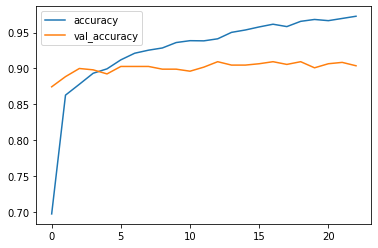

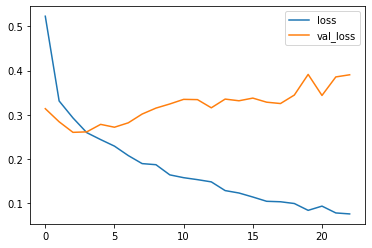

17/17 [==============================] - 6s 250ms/step
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       530
           1       0.94      0.88      0.91       530

    accuracy                           0.91      1060
   macro avg       0.91      0.91      0.91      1060
weighted avg       0.91      0.91      0.91      1060

Precision avg : 0.9111258865248226
Recall avg : 0.909433962264151


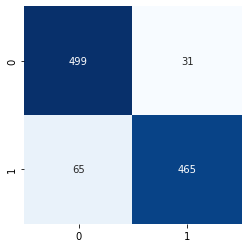

21/21 [==============================] - 5s 239ms/step
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       664
           1       0.95      0.89      0.92       663

    accuracy                           0.92      1327
   macro avg       0.92      0.92      0.92      1327
weighted avg       0.92      0.92      0.92      1327

Precision avg : 0.9241591874035698
Recall avg : 0.9223813112283346


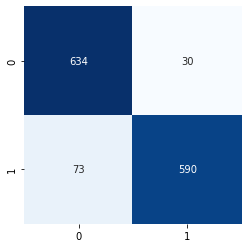

In [ ]:
plot_acc_loss(history)
result_table_valid = evaluation(model,ds_valid_encoded_bert,y_valid,result_table_valid,'IndoBERT-p1',64,.5)
result_table = evaluation(model,ds_unseen_encoded_bert,y_unseen,result_table,'IndoBERT-p1',64,.5)

In [ ]:
result_table_valid.iloc[[-1]].to_csv('train7_model1_valid.csv')
result_table.iloc[[-1]].to_csv('train7_model1_unseen.csv')

In [38]:
tf.keras.backend.clear_session()
model2 = TFXLMRobertaForSequenceClassification.from_pretrained('cahya/xlm-roberta-large-indonesian-NER',hidden_dropout_prob=.3,num_labels=1,from_pt=True)

Downloading:   0%|          | 0.00/2.09G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaForSequenceClassification: ['classifier.weight', 'classifier.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFXLMRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFXLMRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on 

In [39]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=9e-6, epsilon=1e-11),
              loss=loss,
              metrics=['accuracy'])

In [40]:
history = model2.fit(ds_train_encoded_roberta,
                    epochs=50,
                    validation_data=ds_valid_encoded_roberta,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=10,restore_best_weights=True)]
                    )

Epoch 1/50
133/133 [==============================] - 227s 1s/step - loss: 0.6941 - accuracy: 0.5100 - val_loss: 0.6540 - val_accuracy: 0.5000
Epoch 2/50
133/133 [==============================] - 188s 1s/step - loss: 0.6227 - accuracy: 0.6136 - val_loss: 0.5150 - val_accuracy: 0.7745
Epoch 3/50
133/133 [==============================] - 188s 1s/step - loss: 0.4993 - accuracy: 0.7537 - val_loss: 0.3776 - val_accuracy: 0.8519
Epoch 4/50
133/133 [==============================] - 188s 1s/step - loss: 0.4455 - accuracy: 0.7886 - val_loss: 0.3778 - val_accuracy: 0.8585
Epoch 5/50
133/133 [==============================] - 188s 1s/step - loss: 0.3948 - accuracy: 0.8198 - val_loss: 0.3250 - val_accuracy: 0.8830
Epoch 6/50
133/133 [==============================] - 188s 1s/step - loss: 0.3491 - accuracy: 0.8490 - val_loss: 0.2792 - val_accuracy: 0.8858
Epoch 7/50
133/133 [==============================] - 187s 1s/step - loss: 0.3312 - accuracy: 0.8566 - val_loss: 0.3101 - val_accuracy: 0.8972

34/34 [==============================] - 18s 366ms/step
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       530
           1       0.94      0.88      0.91       530

    accuracy                           0.91      1060
   macro avg       0.91      0.91      0.91      1060
weighted avg       0.91      0.91      0.91      1060

Precision avg : 0.9140699025654777
Recall avg : 0.9122641509433962


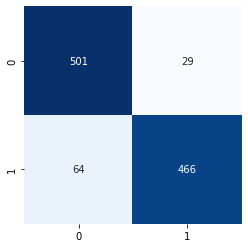

42/42 [==============================] - 16s 375ms/step
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       664
           1       0.95      0.88      0.91       663

    accuracy                           0.92      1327
   macro avg       0.92      0.92      0.92      1327
weighted avg       0.92      0.92      0.92      1327

Precision avg : 0.9191166418142717
Recall avg : 0.9171062547098718


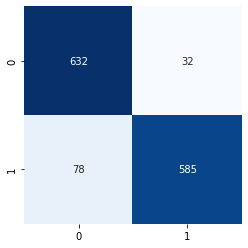

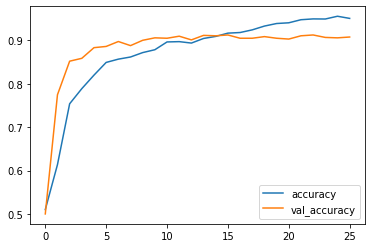

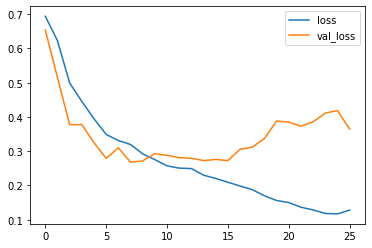

In [41]:
result_table_valid = evaluation(model2,ds_valid_encoded_roberta,y_valid,result_table_valid,'cahya/XLM-RoBERTa-large',32,.5)
result_table = evaluation(model2,ds_unseen_encoded_roberta,y_unseen,result_table,'cahya/XLM-RoBERTa-large',32,.5)
plot_acc_loss(history)

In [42]:
result_table_valid.iloc[[-1]].to_csv('train7_model2_valid.csv')
result_table.iloc[[-1]].to_csv('train7_model2_unseen.csv')

### Bias cause

In [ ]:
pred = model2.predict(ds_unseen_encoded_roberta,batch_size=32, verbose=1)[0]

42/42 [==============================] - 15s 356ms/step


In [ ]:
result = (pred > .5).astype('int32')

In [ ]:
y_unseen[0]

1

In [ ]:
X_unseen[(result.ravel()!=y_unseen) & (y_unseen==1)]

,title
12,pixel akan hadir oktober
13,selain tuai pujian episode perdana pengantin d...
16,tak ingin banyak dituntut dita soedarjo ingin ...
21,tak terima disamakan dengan demo mahasiswa par...
30,ketua kpk ke pegawainya ikhtiar kamu melawan k...
...,...
1167,tuai kontroversi livi zheng enggan berkomentar
1194,sinopsis orang ketiga selasa september aris ...
1218,nikah putri baptis putin show striptis di depa...
1294,sby dan air mata rindu untuk sang belahan hati...


As expected a variant range topic of news contains unique keywords

In [ ]:
X_train['title'].str.contains('pixel').sum()

0

In [ ]:
X_train['title'].str.contains('soedarjo').sum()

0

In [ ]:
X_train['title'].str.contains('ikhtiar').sum()

0

In [ ]:
X_train['title'].str.contains('mobil').sum()

68

In [ ]:
model3 = TFRobertaForSequenceClassification.from_pretrained('cahya/roberta-base-indonesian-522M',hidden_dropout_prob=.5,num_labels=1)

Downloading:   0%|          | 0.00/637M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at cahya/roberta-base-indonesian-522M and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=9e-6, epsilon=1e-11),
              loss=loss,
              metrics=['accuracy'])

In [ ]:
history3 = model3.fit(ds_train_encoded_roberta_base,
                    epochs=50,
                    validation_data=ds_valid_encoded_roberta_base,
                    callbacks=callbacks
                    )

Epoch 1/50
67/67 [==============================] - 72s 820ms/step - loss: 0.6893 - accuracy: 0.5223 - val_loss: 0.6159 - val_accuracy: 0.5066
Epoch 2/50
67/67 [==============================] - 53s 787ms/step - loss: 0.5678 - accuracy: 0.6733 - val_loss: 0.4950 - val_accuracy: 0.7594
Epoch 3/50
67/67 [==============================] - 54s 799ms/step - loss: 0.4519 - accuracy: 0.7872 - val_loss: 0.4553 - val_accuracy: 0.8047
Epoch 4/50
67/67 [==============================] - 53s 796ms/step - loss: 0.4187 - accuracy: 0.8125 - val_loss: 0.4069 - val_accuracy: 0.8406
Epoch 5/50
67/67 [==============================] - 53s 795ms/step - loss: 0.3922 - accuracy: 0.8280 - val_loss: 0.3771 - val_accuracy: 0.8509
Epoch 6/50
67/67 [==============================] - 53s 797ms/step - loss: 0.3688 - accuracy: 0.8377 - val_loss: 0.3771 - val_accuracy: 0.8585
Epoch 7/50
67/67 [==============================] - 53s 792ms/step - loss: 0.3441 - accuracy: 0.8457 - val_loss: 0.3802 - val_accuracy: 0.8575

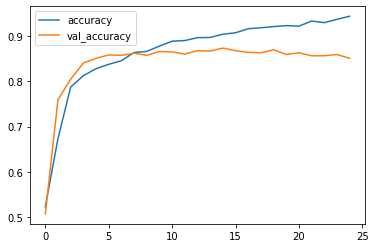

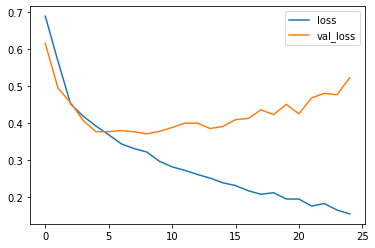

17/17 [==============================] - 5s 236ms/step
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       530
           1       0.89      0.85      0.87       530

    accuracy                           0.87      1060
   macro avg       0.87      0.87      0.87      1060
weighted avg       0.87      0.87      0.87      1060

Precision avg : 0.8741176470588234
Recall avg : 0.8735849056603774


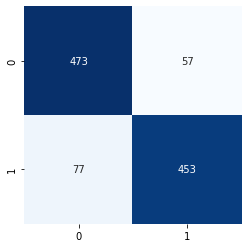

In [ ]:
plot_acc_loss(history3)
result_table_valid = evaluation(model3,ds_valid_encoded_roberta_base,y_valid,result_table_valid,'cahya/RoBERTa-base',64,.5)

21/21 [==============================] - 5s 227ms/step
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       664
           1       0.89      0.88      0.88       663

    accuracy                           0.88      1327
   macro avg       0.88      0.88      0.88      1327
weighted avg       0.88      0.88      0.88      1327

Precision avg : 0.8817295665141492
Recall avg : 0.881688018085908


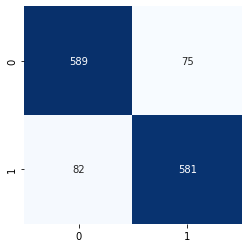

In [ ]:
result_table = evaluation(model3,ds_unseen_encoded_roberta_base,y_unseen,result_table,'cahya/RoBERTa-base',64,.5)

In [ ]:
result_table_valid.iloc[[-1]].to_csv('train7_model3_valid.csv')
result_table.iloc[[-1]].to_csv('train7_model3_unseen.csv')

In [ ]:
tf.keras.backend.clear_session()
model4 = TFBertForSequenceClassification.from_pretrained('cahya/bert-base-indonesian-522M',hidden_dropout_prob=.5,num_labels=1)

Downloading:   0%|          | 0.00/520M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-522M and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=9e-6, epsilon=1e-11),
              loss=loss,
              metrics=['accuracy'])

In [ ]:
history4 = model4.fit(ds_train_encoded_cahya_bert,
                    epochs=50,
                    validation_data=ds_valid_encoded_cahya_bert,
                    callbacks=callbacks
                    )

Epoch 1/50
67/67 [==============================] - 79s 824ms/step - loss: 0.6629 - accuracy: 0.5461 - val_loss: 0.5309 - val_accuracy: 0.6745
Epoch 2/50
67/67 [==============================] - 53s 787ms/step - loss: 0.4875 - accuracy: 0.7577 - val_loss: 0.3900 - val_accuracy: 0.8462
Epoch 3/50
67/67 [==============================] - 52s 775ms/step - loss: 0.3998 - accuracy: 0.8250 - val_loss: 0.3818 - val_accuracy: 0.8528
Epoch 4/50
67/67 [==============================] - 53s 792ms/step - loss: 0.3684 - accuracy: 0.8408 - val_loss: 0.3621 - val_accuracy: 0.8698
Epoch 5/50
67/67 [==============================] - 52s 773ms/step - loss: 0.3483 - accuracy: 0.8464 - val_loss: 0.3497 - val_accuracy: 0.8726
Epoch 6/50
67/67 [==============================] - 53s 793ms/step - loss: 0.3118 - accuracy: 0.8674 - val_loss: 0.3577 - val_accuracy: 0.8755
Epoch 7/50
67/67 [==============================] - 53s 789ms/step - loss: 0.3030 - accuracy: 0.8773 - val_loss: 0.3566 - val_accuracy: 0.8774

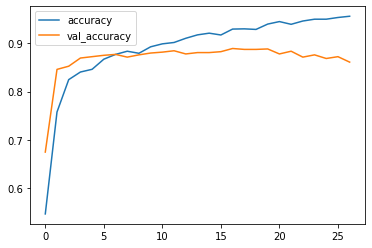

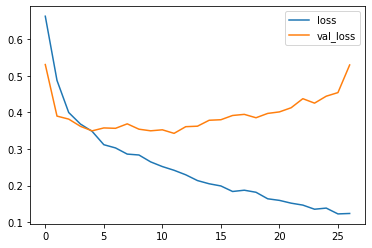

17/17 [==============================] - 7s 243ms/step
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       530
           1       0.93      0.84      0.88       530

    accuracy                           0.89      1060
   macro avg       0.89      0.89      0.89      1060
weighted avg       0.89      0.89      0.89      1060

Precision avg : 0.893558223746903
Recall avg : 0.8896226415094339


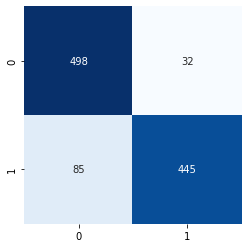

In [ ]:
plot_acc_loss(history4)
result_table_valid = evaluation(model4,ds_valid_encoded_cahya_bert,y_valid,result_table_valid,'cahya/BERT-base',64,.5)

21/21 [==============================] - 5s 247ms/step
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       664
           1       0.94      0.86      0.90       663

    accuracy                           0.91      1327
   macro avg       0.91      0.91      0.90      1327
weighted avg       0.91      0.91      0.90      1327

Precision avg : 0.9079493464356572
Recall avg : 0.9050489826676714


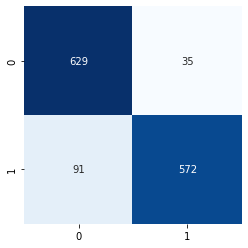

In [ ]:
result_table = evaluation(model4,ds_unseen_encoded_cahya_bert,y_unseen,result_table,'cahya/BERT-base',64,.5)

In [ ]:
result_table_valid.iloc[[-1]].to_csv('train7_model4_valid.csv')
result_table.iloc[[-1]].to_csv('train7_model4_unseen.csv')

In [43]:
result_table_valid = pd.concat([pd.read_csv('train7_model1_valid.csv'),pd.read_csv('train7_model2_valid.csv').iloc[[-1]],pd.read_csv('train7_model3_valid.csv'),pd.read_csv('train7_model4_valid.csv').iloc[[-1]]])

In [44]:
result_table_valid.drop(result_table_valid.columns[0], axis=1, inplace=True)

In [45]:
result_table_valid.set_index('classifiers', inplace=True)

In [46]:
result_table_valid = result_table_valid.applymap(lambda x : [ float(i) for i in x.replace('[','').replace(']','').replace(',','').split(' ') if i!= ''] if isinstance(x, str) else x)

In [47]:
result_table_valid

,fpr,tpr,auc
classifiers,,,
IndoBERT-p1,"[0.0, 0.05849057, 1.0]","[0.0, 0.87735849, 1.0]",0.909434
cahya/XLM-RoBERTa-large,"[0.0, 0.05471698, 1.0]","[0.0, 0.87924528, 1.0]",0.912264
cahya/RoBERTa-base,"[0.0, 0.10754717, 1.0]","[0.0, 0.85471698, 1.0]",0.873585
cahya/BERT-base,"[0.0, 0.06037736, 1.0]","[0.0, 0.83962264, 1.0]",0.889623


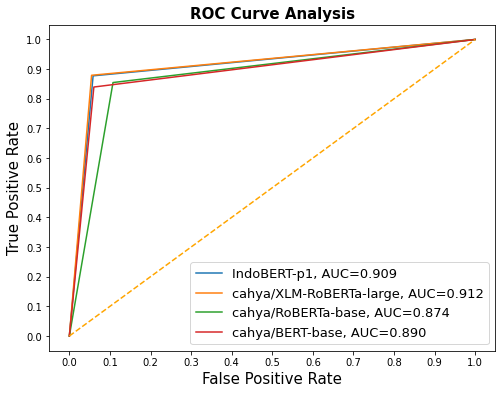

In [48]:
import numpy as np


fig = plt.figure(figsize=(8,6))

for i in result_table_valid.index:
    plt.plot(result_table_valid.loc[i]['fpr'], 
             result_table_valid.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table_valid.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [50]:
result_table = pd.concat([pd.read_csv('train7_model1_unseen.csv'),pd.read_csv('train7_model2_unseen.csv').iloc[[-1]],pd.read_csv('train7_model3_unseen.csv'),pd.read_csv('train7_model4_unseen.csv').iloc[[-1]]])

In [51]:
result_table.drop(result_table.columns[0], axis=1, inplace=True)

In [52]:
result_table.set_index('classifiers', inplace=True)

In [53]:
result_table = result_table.applymap(lambda x : [ float(i) for i in x.replace('[','').replace(']','').replace(',','').split(' ') if i!= ''] if isinstance(x, str) else x)

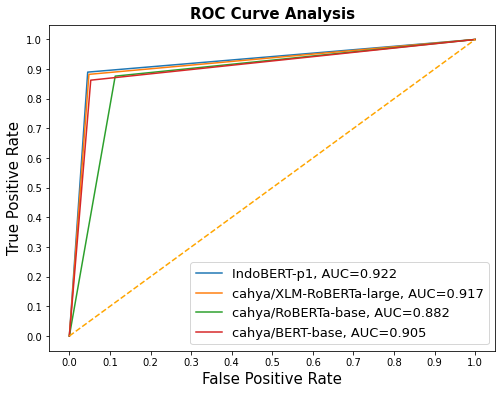

In [54]:
import numpy as np


fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()